In [1]:
import requests
import json
import matplotlib.pyplot as plt
from xgrads import open_CtlDataset
import ulmo
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
from collections import OrderedDict
import numpy as np
from rasterstats import point_query
from datetime import datetime, timedelta, date

In [2]:
domain = 'UT'
mode = 'all'
stdt = '2018-10-01'
eddt = '2019-09-30'

# SNOTEL 

In [3]:
#functions to get snotel data 
# functions to get SNOTEL stations as geodataframe
def sites_asgdf(ulmo_getsites, stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=stn_proj
    )
    return sites_gdf

def get_snotel_stns(domain):
    
    #path to CSO domains
    domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
    domains = domains_resp.json()

    #Snotel bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
    
    # WaterML/WOF WSDL endpoint url 
    if domain == 'NH':
        wsdlurl = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    else:
        wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

    # get dictionary of snotel sites 
    sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

    #turn sites to geodataframe 
    snotel_gdf = sites_asgdf(sites,stn_proj)
    
    #clip snotel sites to domain bounding box
    gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
    gdf.drop(columns='index_right', inplace=True)
    gdf.reset_index(drop=True, inplace=True)

    #add columns with projected coordinates 
    CSO_proj = gdf.to_crs(mod_proj)
    gdf['easting'] = CSO_proj.geometry.x
    gdf['northing'] = CSO_proj.geometry.y
    
    return gdf


def fetch(sitecode, variablecode, domain,start_date, end_date):
    print(sitecode, variablecode, domain,start_date, end_date)
    values_df = None
    # WaterML/WOF WSDL endpoint url 
    if domain == 'NH':
        wsdlurl = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
        network = 'SCAN:'
    else:
        wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"
        network = 'SNOTEL:'

    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, network+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df


# returns daily timeseries of snotel variables 
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_snotel_data(gdf,sddt, eddt,var,domain,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    stn_data = pd.DataFrame(index=pd.date_range(start=stdt, end=eddt))
    if domain == 'NH':
        network = 'SCAN:'
    else:
        network = 'SNOTEL:'    

    for sitecode in gdf.code:
        try:
            data = fetch(sitecode,network+var+'_D', domain, start_date=stdt, end_date=eddt)
            #check for nan values
            if len(data.value[np.isnan(data.value)]) > 0:
                #check if more than 10% of data is missing
                if len(data.value[np.isnan(data.value)])/len(data) > .02:
                    print('More than 2% of days missing')
                    gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
                    continue
            stn_data[sitecode] = data.value
        except:
            gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)     
    
    gdf.reset_index(drop=True, inplace=True)
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert SNOTEL units[in] to [m]
            for sitecode in gdf.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert SNOTEL units[F] to [C]
            for sitecode in gdf.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
    return gdf, stn_data

snotelgdf = get_snotel_stns(domain)
snotel_gdf, swes = get_snotel_data(snotelgdf,stdt,eddt,'WTEQ',domain)

366_UT_SNTL SNOTEL:WTEQ_D UT 2018-10-01 2019-09-30
628_UT_SNTL SNOTEL:WTEQ_D UT 2018-10-01 2019-09-30
766_UT_SNTL SNOTEL:WTEQ_D UT 2018-10-01 2019-09-30
814_UT_SNTL SNOTEL:WTEQ_D UT 2018-10-01 2019-09-30


In [4]:
len(snotel_gdf)

4

# CSO data

In [4]:
#########################################################################
# CSO Functions
#########################################################################
# Function to get SWE from CSO Hs

def swe_calc(gdf):
    #convert snow depth to mm to input into density function
    H = gdf.depth.values*10
    #Get temp info at each point
    TD = np.array([point_query([val], 'td_final.txt')[0] for val in gdf.geometry])
    #Get pr info at each point
    PPTWT = np.array([point_query([val], 'ppt_wt_final.txt')[0] for val in gdf.geometry])
    #Determine day of year
    dates = pd.to_datetime(gdf.timestamp, format='%Y-%m-%dT%H:%M:%S').dt.date.values
    DOY = [date.toordinal(date(dts.year,dts.month,dts.day))-date.toordinal(date(dts.year,9,30)) for dts in dates]
    DOY = np.array([doy + 365 if doy < 0 else doy for doy in DOY])
    #Apply regression equation 
    a = [0.0533,0.948,0.1701,-0.1314,0.2922] #accumulation phase
    b = [0.0481,1.0395,0.1699,-0.0461,0.1804]; #ablation phase
    SWE = a[0]*H**a[1]*PPTWT**a[2]*TD**a[3]*DOY**a[4]*(-np.tanh(.01*\
            (DOY-180))+1)/2 + b[0]*H**b[1]*PPTWT**b[2]*TD**b[3]*DOY**b[4]*\
            (np.tanh(.01*(DOY-180))+1)/2;
    #convert swe to m to input into SM
    gdf['swe'] = SWE/1000
    gdf['doy'] = DOY
    gdf['H'] = H
    return gdf


# Function to build geodataframe of CSO point observations 

def get_cso(st, ed, domain):
    ''' 
    st = start date 'yyyy-mm-dd'
    ed = end date 'yyyy-mm-dd'
    domain = string label of defined CSO domain
    '''
    
    #path to CSO domains
    domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
    domains = domains_resp.json()

    Bbox = domains[domain]['Bbox']
    stn_proj = domains[domain]['stn_proj']
    mod_proj = domains[domain]['mod_proj']
    
    #Issue CSO API observations request and load the results into a GeoDataFrame
    params = {
      "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
      "start_date": st,
      "end_date": ed,
      "format": "geojson",
      "limit": 5000,
    }

    csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
    csodatajson = csodata_resp.json()
    #turn into geodataframe
    gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)
    
    mask = (gdf['timestamp'] >= st) & (gdf['timestamp'] <= ed)
    gdf = gdf.loc[mask]
    gdf=gdf.reset_index(drop=True)
    print('Total number of CSO in domain = ',len(gdf))

    #ingdf = extract_meta(gdf,domain,dem_path,lc_path)
    ingdf = swe_calc(gdf)
    ingdf_proj = ingdf.to_crs(mod_proj)
    
    ingdf['dt'] = pd.to_datetime(ingdf['timestamp'], format='%Y-%m-%dT%H:%M:%S').dt.date
    ingdf['Y'] = pd.DatetimeIndex(ingdf['dt']).year
    ingdf['M'] = pd.DatetimeIndex(ingdf['dt']).month
    ingdf['D'] = pd.DatetimeIndex(ingdf['dt']).day
    ingdf["x"] = ingdf_proj.geometry.x
    ingdf["y"] = ingdf_proj.geometry.y
    
    return ingdf


# QA/QC function for CSO data
def qaqc_iqr(csodf):
    print('Performing qa/qc on CSO data using IQR method')
    clim_dir = '/nfs/attic/dfh/data/snodas/snodas_tif/clim/'
    iqr_flag = []
    for i in range(len(csodf)):
        # get cso snow depth
        csohs = csodf.H[i]
        # get date
        dates = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')

        # define path names for 1st and 3rd doy quantiles
        q1_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q1.tif'
        q3_Fname = clim_dir+dates.strftime("%m")+dates.strftime("%d")+'1036q3.tif'

        q1 = point_query([csodf.geometry[i]], q1_Fname)[0]
        q3 = point_query([csodf.geometry[i]], q3_Fname)[0]
        IQR = q3-q1
        # False = outlier
        iqr_flag.append((csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))

    csodf['iqr_flag'] = iqr_flag
    csodf_clean = csodf.loc[csodf['iqr_flag'] == True]
    csodf_clean = csodf_clean.reset_index(drop=True)
    print('Total number of CSO in domain after qa/qc= ',len(csodf_clean))
    return csodf_clean

CSOgdf = get_cso(stdt, eddt, domain)
CSOgdf_clean = qaqc_iqr(CSOgdf)

Total number of CSO in domain =  117
Performing qa/qc on CSO data using IQR method


/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Total number of CSO in domain after qa/qc=  111


In [47]:
CSOgdf_clean[CSOgdf_clean.author == "Brooks Taylor"]

,geometry,id,author,depth,source,timestamp,elevation,swe,doy,H,dt,Y,M,D,x,y,iqr_flag
249,POINT (-110.58022 43.67194),lQV6WjoK,Brooks Taylor,70.0,MountainHub,2019-04-16T16:26:35.856Z,2294.961182,0.239161,198,700.0,2019-04-16,2019,4,16,533840.087554,4.835523e+06,True
263,POINT (-110.58718 43.66669),nqHz1dCx,Brooks Taylor,63.0,MountainHub,2019-04-16T16:03:13.807Z,2184.259521,0.212466,198,630.0,2019-04-16,2019,4,16,533282.047322,4.834937e+06,True
267,POINT (-110.59060 43.66645),UnW4FNU+,Brooks Taylor,56.0,MountainHub,2019-04-16T16:00:20.243Z,2174.378906,0.188492,198,560.0,2019-04-16,2019,4,16,533006.571158,4.834908e+06,True
271,POINT (-110.59067 43.66640),qAVGgnOV,Brooks Taylor,63.0,MountainHub,2019-04-16T15:58:28.787Z,2174.102051,0.212183,198,630.0,2019-04-16,2019,4,16,533000.945015,4.834904e+06,True
286,POINT (-110.57032 43.67384),O/NRUcXH,Brooks Taylor,143.0,MountainHub,2019-04-10T17:27:39.795Z,2354.515381,0.494780,192,1430.0,2019-04-10,2019,4,10,534637.408273,4.835738e+06,True
294,POINT (-110.54802 43.61037),3hgH1osz,Brooks Taylor,176.0,MountainHub,2019-03-15T17:55:38.548Z,2741.920654,0.578440,166,1760.0,2019-03-15,2019,3,15,536473.472424,4.828698e+06,True
303,POINT (-110.59230 43.67118),2GZwEcBW,Brooks Taylor,111.0,MountainHub,2019-03-04T21:36:15.799Z,2155.302002,0.337254,155,1110.0,2019-03-04,2019,3,4,532866.745887,4.835433e+06,True
326,POINT (-110.58041 43.67251),mhdjFg/V,Brooks Taylor,101.0,MountainHub,2019-02-22T19:58:53.405Z,2215.552979,0.302962,145,1010.0,2019-02-22,2019,2,22,533824.479337,4.835586e+06,True
336,POINT (-110.59499 43.66938),FugX4IH9,Brooks Taylor,110.0,MountainHub,2019-02-07T19:15:39.175Z,2162.676514,0.310436,130,1100.0,2019-02-07,2019,2,7,532651.035045,4.835232e+06,True
345,POINT (-110.58398 43.70683),15sLCPvp,Brooks Taylor,76.0,MountainHub,2019-01-29T20:01:51.499Z,2402.239014,0.221030,121,760.0,2019-01-29,2019,1,29,533517.987179,4.839396e+06,True


In [ ]:
df.groupby('group')['value'].rank(ascending=False)

In [6]:
dfs=CSOgdf_clean.groupby(['author'])['swe'].count().sort_values()
dfs

author
zinnia wilson          1
Douglas  Catharine     1
Robert  Kosinski       1
Drew Keeve             1
Robby Jost             1
                      ..
mark saurer           10
Erme Catino           12
Noah Keller           12
Evelyn Lees           14
Mark Staples          29
Name: swe, Length: 125, dtype: int64

In [11]:
# view how many observations each CSO participant submitted 
for idx in dfs.index:
    print(idx,dfs[idx])

zinnia wilson 1
Douglas  Catharine 1
Robert  Kosinski 1
Drew Keeve 1
Robby Jost 1
Elizabeth Hinds 1
Randy Hartwig 1
Nick Pobat 1
Nick McCabe 1
Eric Trenbeath 1
Nathan Rothe 1
Erik Rhenman 1
Molly Massena 1
Mitch Potter 1
Michelle Altizer 1
Gabe Garcia 1
Michael Skidmore 1
Greg Gagne 1
Katherine  Speare 1
MacLean Wright 1
Matt Park 1
Jim Conway 1
Jesse Robertson 1
Jerrod Finlay 1
Dennis Martin 1
Jeremy Deem 1
Jake Castle 1
Jacob Ramey 1
J M 1
Irene Henninger 1
Ian Reddell 1
Hayden Beck 1
Jennifer Shields 1
David Martin 1
Devin Wilkinson 1
Ryan Fell 1
max gans 1
Annie Putman 1
Arden Feldman 1
Austin DiVesta 1
Banning Starr 1
Zachariah Chatterley 1
Zach Coury 1
Will McKay 1
Brad Marshall 1
Darrell Finlayson 1
Tyson Anderson 1
Tyler Grundstrom 1
Brian Muller 1
Weston Deutschlander 1
Brint Markle 1
Tucker FitzSimons 1
Carl Dec 1
Tanner  Visnick 1
Stanton Mayer 1
Christopher Bremer 1
Shay Blackley 1
Shaun Raskin 1
Brian Walters 1
Scot Hastings 1
trent meisenheimer  2
steven clark 2
Mandy Gei

# SnowModel

In [5]:
# function to edit text files
def replace_line(file_name, line_num, text):
    ''' 
    file_name = file to edit
    line_num = line number in file to edit
    text = nex text to put in
    '''
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

In [6]:
ctlFile = '/nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/swed.ctl'

#op1 assim SM run 
text = 'DSET ^snotel_op_allCSO_swed.gdat\n'
replace_line(ctlFile, 0, text)
op1 = open_CtlDataset(ctlFile)

# #op2 assim SM run 
text = 'DSET ^snotel_op_deltaCSO_swed.gdat\n'
replace_line(ctlFile, 0, text)
op2 = open_CtlDataset(ctlFile)

#baseline SM run 
text = 'DSET ^baseline_swed.gdat\n'
replace_line(ctlFile, 0, text)
baseswe = open_CtlDataset(ctlFile)

# #cso assim SM run 
text = 'DSET ^cso_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
csoswe = open_CtlDataset(ctlFile)

# #snotel assim SM run 
text = 'DSET ^snotel_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
snotelswe = open_CtlDataset(ctlFile)

#both assim SM run 
text = 'DSET ^both_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
bothswe = open_CtlDataset(ctlFile)

In [50]:
baseswe

,Array,Chunk
Bytes,2.85 GB,7.81 MB
Shape,"(365, 1366, 1429)","(1, 1366, 1429)"
Count,730 Tasks,365 Chunks
Type,float32,numpy.ndarray


In [21]:
baseswe.swed.isel(time = 20)

<xarray.DataArray 'swed' (lat: 2476, lon: 1382)>
dask.array<getitem, shape=(2476, 1382), dtype=float32, chunksize=(2476, 1382), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2018-10-21
  * lat      (lat) float32 4690100.0 4690200.0 4690300.0 ... 4937500.0 4937600.0
  * lon      (lon) float32 487200.0 487300.0 487400.0 ... 625200.0 625300.0
Attributes:
    comment:  snow-water-equivalent depth
    storage:  0

In [22]:
ctlFile = '/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/ctl_files/wo_assim/swed.ctl'
#baseline SM run 
# text = 'DSET ^baseline_swed.gdat\n'
# replace_line(ctlFile, 0, text)
baseswe = open_CtlDataset(ctlFile)

# # #cso assim SM run 
# text = 'DSET ^cso_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# csoswe = open_CtlDataset(ctlFile)

# # #snotel assim SM run 
# text = 'DSET ^snotel_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# snotelswe = open_CtlDataset(ctlFile)
ctlFile = '/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WY/ctl_files/wi_assim/swed.ctl'
#both assim SM run 
# text = 'DSET ^both_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
bothswe = open_CtlDataset(ctlFile)

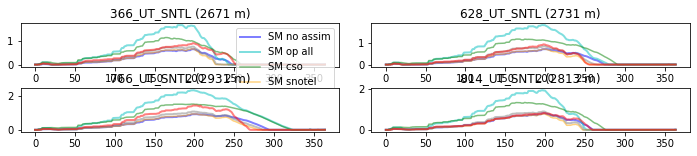

In [7]:
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = float(domains[domain]['nrows'])
nx = float(domains[domain]['ncols'])

eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)


elev = snotelgdf['elevation_m'].values
station = snotelgdf['code'].values

fig, axs = plt.subplots(nrows=int(np.ceil(len(snotelgdf)/2)), figsize=(12, len(snotelgdf)-2), ncols=2, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(snotelgdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = swes[nam].values
    pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
    ops1 = op1.swed.isel(lon = xval,lat = yval).values
#     ops2 = op2.swed.isel(lon = xval,lat = yval).values
    cso = csoswe.swed.isel(lon = xval,lat = yval).values
    snotel = snotelswe.swed.isel(lon = xval,lat = yval).values
    both = bothswe.swed.isel(lon = xval,lat = yval).values
    axs[i].plot(base,color='b', label ='SM no assim',alpha = 0.5,linewidth=2)
    axs[i].plot(ops1,color='c', label ='SM op all',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops2,color='pink', label ='SM op delta',alpha = 0.5,linewidth=2)
    axs[i].plot(cso,color='g', label ='SM cso',alpha = 0.5)
    axs[i].plot(snotel,color='orange', label ='SM snotel',alpha = 0.5)
    axs[i].plot(both,color='grey', label ='SM both',alpha = 0.5,linewidth=2)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5,linewidth=2)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(loc='upper right',)

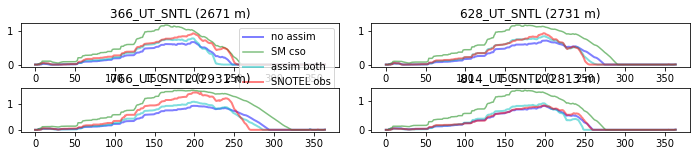

In [8]:
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = float(domains[domain]['nrows'])
nx = float(domains[domain]['ncols'])

eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)


elev = snotelgdf['elevation_m'].values
station = snotelgdf['code'].values

fig, axs = plt.subplots(nrows=int(np.ceil(len(snotelgdf)/2)), figsize=(12, len(snotelgdf)-2), ncols=2, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(snotelgdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = swes[nam].values
    pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
#     ops1 = op1.swed.isel(lon = xval,lat = yval).values
#     ops2 = op2.swed.isel(lon = xval,lat = yval).values
    cso = csoswe.swed.isel(lon = xval,lat = yval).values
#     snotel = snotelswe.swed.isel(lon = xval,lat = yval).values
    both = bothswe.swed.isel(lon = xval,lat = yval).values
    axs[i].plot(base,color='b', label ='no assim',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops1,color='c', label ='SM op all',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops2,color='pink', label ='SM op delta',alpha = 0.5,linewidth=2)
    axs[i].plot(cso,color='g', label ='SM cso',alpha = 0.5)
#     axs[i].plot(snotel,color='orange', label ='SM snotel',alpha = 0.5)
    axs[i].plot(both,color='c', label ='assim both',alpha = 0.5,linewidth=2)
    axs[i].plot(obs,color='r',label ='SNOTEL obs',alpha = 0.5,linewidth=2)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(loc='upper right',)

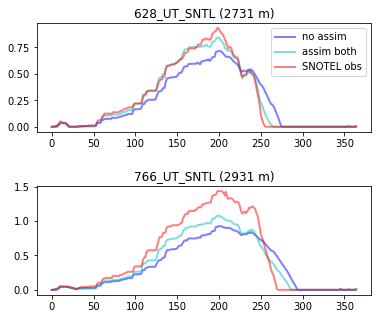

In [15]:
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = float(domains[domain]['nrows'])
nx = float(domains[domain]['ncols'])

eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)


elev = snotelgdf['elevation_m'].values
station = snotelgdf['code'].values

fig, axs = plt.subplots(nrows=2, figsize=(6,5), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in [1,2]:
    nam = station[i]
    el = elev[i]
    obs = swes[nam].values
    pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
#     ops1 = op1.swed.isel(lon = xval,lat = yval).values
#     ops2 = op2.swed.isel(lon = xval,lat = yval).values
    cso = csoswe.swed.isel(lon = xval,lat = yval).values
#     snotel = snotelswe.swed.isel(lon = xval,lat = yval).values
    both = bothswe.swed.isel(lon = xval,lat = yval).values
    axs[i-1].plot(base,color='b', label ='no assim',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops1,color='c', label ='SM op all',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops2,color='pink', label ='SM op delta',alpha = 0.5,linewidth=2)
#     axs[i].plot(cso,color='g', label ='SM cso',alpha = 0.5)
#     axs[i].plot(snotel,color='orange', label ='SM snotel',alpha = 0.5)
    axs[i-1].plot(both,color='c', label ='assim both',alpha = 0.5,linewidth=2)
    axs[i-1].plot(obs,color='r',label ='SNOTEL obs',alpha = 0.5,linewidth=2)
    axs[i-1].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 1:
        axs[i-1].legend(loc='upper right',)

In [16]:
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'
path = figpath + 'usaw_2019_swe_timeseries_'+domain+'.png'
fig.savefig(path, dpi=300)

In [ ]:
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = float(domains[domain]['nrows'])
nx = float(domains[domain]['ncols'])

eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)


elev = snotelgdf['elevation_m'].values
station = snotelgdf['code'].values

fig, axs = plt.subplots(1,figsize=(8,6),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
i = 0
# 1, 2, 3, 4, 5, 

nam = station[i]
el = elev[i]
obs = swes[nam].values
pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
base = baseswe.swed.isel(lon = xval,lat = yval).values
#     ops1 = op1.swed.isel(lon = xval,lat = yval).values
#     ops2 = op2.swed.isel(lon = xval,lat = yval).values
#     cso = csoswe.swed.isel(lon = xval,lat = yval).values
#     snotel = snotelswe.swed.isel(lon = xval,lat = yval).values
both = bothswe.swed.isel(lon = xval,lat = yval).values
axs[i].plot(base,color='b', label ='no assim',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops1,color='c', label ='SM op all',alpha = 0.5,linewidth=2)
#     axs[i].plot(ops2,color='pink', label ='SM op delta',alpha = 0.5,linewidth=2)
#     axs[i].plot(cso,color='g', label ='SM cso',alpha = 0.5)
#     axs[i].plot(snotel,color='orange', label ='SM snotel',alpha = 0.5)
axs[i].plot(both,color='c', label ='assim both',alpha = 0.5,linewidth=2)
axs[i].plot(obs,color='r',label ='SNOTEL obs',alpha = 0.5,linewidth=2)
axs[i].set_title(nam+' ('+el[0:4]+' m)')
#axs[i].set_ylim([0, 2])
if i == 0:
    axs[i].legend(loc='upper right',)

Text(0, 0.5, 'SWE [m]')

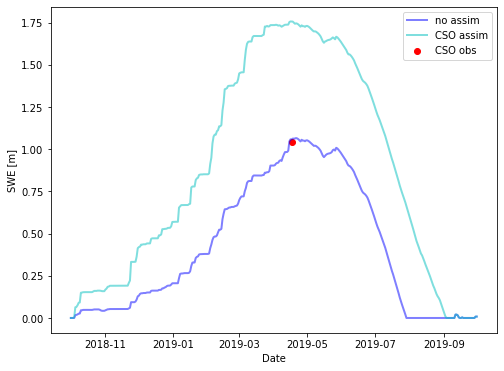

In [9]:
csogdf = CSOgdf_clean
dates = pd.date_range(start=stdt, end=eddt)
fig, axs = plt.subplots(1,figsize=(8,6),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
i = 0
obs = csogdf.iloc[i].swe
idx = np.where(pd.to_datetime(csogdf.dt.iloc[i])==dates) 
pt = (csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
base = baseswe.swed.isel(lon = xval,lat = yval).values
cso = csoswe.swed.isel(lon = xval,lat = yval).values
axs.plot(dates,base,color='b', label ='no assim',alpha = 0.5,linewidth=2)
axs.plot(dates,cso,color='c', label ='CSO assim',alpha = 0.5,linewidth=2)
#axs[i].set_ylim([0, 2])
axs.scatter(dates[idx],obs,color = 'r',label = 'CSO obs')
axs.legend(loc='upper right',)
axs.set_xlabel('Date')
axs.set_ylabel('SWE [m]')

In [28]:
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'
path = figpath + 'wysaw_2019_swe_timeseries_'+domain+'.png'
fig.savefig(path, dpi=300)

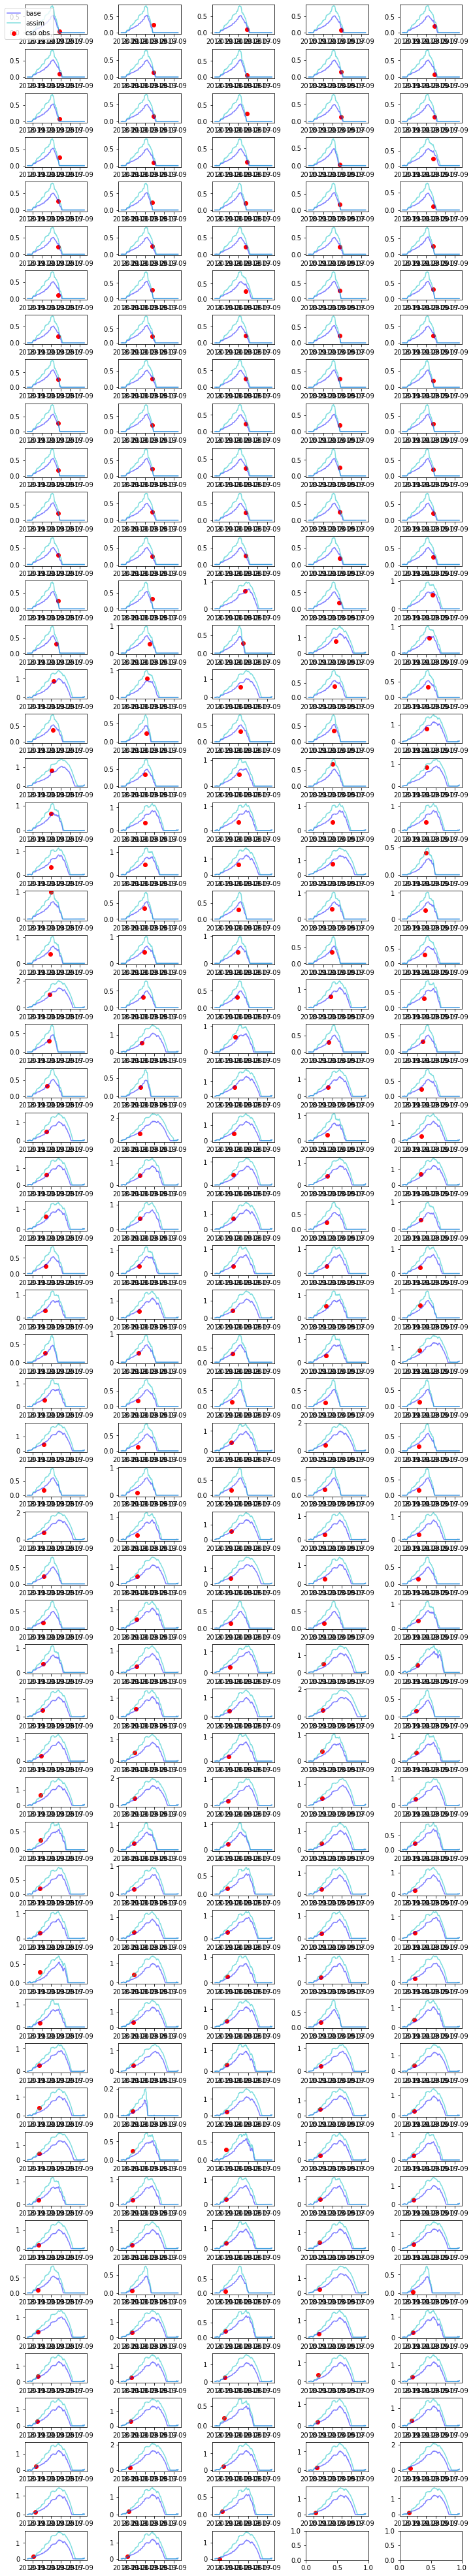

In [26]:
#figure to show swe with and without assim at point corresponding to CSO observations 
csogdf = CSOgdf_clean
dates = pd.date_range(start=stdt, end=eddt)
fig, axs = plt.subplots(nrows=int(np.ceil(len(csogdf)/5)), figsize=(12, len(csogdf)/4), ncols=5, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(csogdf)[0]):

    obs = csogdf.iloc[i].swe
    idx = np.where(pd.to_datetime(csogdf.dt.iloc[i])==dates) 
    pt = (csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
    both = csoswe.swed.isel(lon = xval,lat = yval).values
    axs[i].plot(dates,base,color='b', label ='base',alpha = 0.5)
    axs[i].plot(dates,both,color='c', label ='assim',alpha = 0.5)
    #axs[i].set_ylim([0, 2])
    axs[i].scatter(dates[idx],obs,color = 'r',label = 'cso obs')
    if i == 0:
        axs[i].legend(bbox_to_anchor=(.5, 1),loc='upper right')

# Export KML files

In [6]:
CSOgdf_clean

,geometry,id,author,depth,source,timestamp,elevation,swe,doy,H,dt,Y,M,D,x,y,iqr_flag
0,POINT (-110.96780 43.50090),ysU+1dwO,Adam Davis,60.000000,SnowPilot,2021-04-18T21:00:00.000Z,2553.657715,0.224114,200,600.000000,2021-04-18,2021,4,18,502602.825449,4.816442e+06,True
1,POINT (-110.07724 43.74293),H2413iQv,Lisa Van Sciver,189.000000,SnowPilot,2021-03-16T17:00:00.000Z,2977.434814,0.616446,167,1890.000000,2021-03-16,2021,3,16,574300.615384,4.843735e+06,True
2,POINT (-110.77275 43.65178),vKUaAS6l,James Molloy,125.999995,MountainHub,2021-03-13T23:10:29.993Z,2039.527832,0.385739,164,1259.999953,2021-03-13,2021,3,13,518325.801187,4.833223e+06,True
3,POINT (-110.77695 43.72750),XZdZMb1l,Max Ritter,180.000000,SnowPilot,2021-02-27T19:00:00.000Z,2419.408203,0.624881,150,1800.000000,2021-02-27,2021,2,27,517964.641966,4.841632e+06,True
4,POINT (-111.04521 43.52886),/H/kDERz,Luke LeMaire,235.000000,SnowPilot,2021-02-27T19:00:00.000Z,2402.130615,0.732168,150,2350.000000,2021-02-27,2021,2,27,496346.526618,4.819547e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,POINT (-110.08168 43.74282),xIxo+Cye,Chris McCollister,105.000000,SnowPilot,2017-12-02T23:32:12.000Z,2955.633789,0.241877,63,1050.000000,2017-12-02,2017,12,2,573942.672434,4.843719e+06,True
649,POINT (-110.93372 43.77748),JuPczV/o,Andrew Ryan,108.000000,SnowPilot,2017-12-02T22:43:58.000Z,2490.803711,0.257439,63,1080.000000,2017-12-02,2017,12,2,505333.921272,4.847160e+06,True
650,POINT (-110.44920 42.39061),arcK8q2n,Don Sharaf,48.000000,SnowPilot,2017-11-30T00:53:51.000Z,2869.696533,0.111483,61,480.000000,2017-11-30,2017,11,30,545335.645423,4.693294e+06,True
651,POINT (-110.06337 43.77902),R9UFTt9E,Chris McCollister,95.000000,SnowPilot,2017-11-24T18:13:54.000Z,2984.750244,0.211825,55,950.000000,2017-11-24,2017,11,24,575371.457641,4.847756e+06,True


In [7]:
CSOgdf

,geometry,id,author,depth,source,timestamp,elevation,swe,doy,H,dt,Y,M,D,x,y,iqr_flag
0,POINT (-110.96780 43.50090),ysU+1dwO,Adam Davis,60.000000,SnowPilot,2021-04-18T21:00:00.000Z,2553.657715,0.224114,200,600.000000,2021-04-18,2021,4,18,502602.825449,4.816442e+06,True
1,POINT (-110.07724 43.74293),H2413iQv,Lisa Van Sciver,189.000000,SnowPilot,2021-03-16T17:00:00.000Z,2977.434814,0.616446,167,1890.000000,2021-03-16,2021,3,16,574300.615384,4.843735e+06,True
2,POINT (-110.77275 43.65178),vKUaAS6l,James Molloy,125.999995,MountainHub,2021-03-13T23:10:29.993Z,2039.527832,0.385739,164,1259.999953,2021-03-13,2021,3,13,518325.801187,4.833223e+06,True
3,POINT (-110.77695 43.72750),XZdZMb1l,Max Ritter,180.000000,SnowPilot,2021-02-27T19:00:00.000Z,2419.408203,0.624881,150,1800.000000,2021-02-27,2021,2,27,517964.641966,4.841632e+06,True
4,POINT (-111.04521 43.52886),/H/kDERz,Luke LeMaire,235.000000,SnowPilot,2021-02-27T19:00:00.000Z,2402.130615,0.732168,150,2350.000000,2021-02-27,2021,2,27,496346.526618,4.819547e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,POINT (-110.86834 43.58897),CdEMMos4,Chris McCollister,120.000000,SnowPilot,2017-11-08T19:48:58.000Z,2875.455811,0.251904,39,1200.000000,2017-11-08,2017,11,8,510628.564375,4.826231e+06,False
712,POINT (-110.94627 43.51751),w0auLQBa,Jacob Urban,330.200000,MountainHub,2017-11-07T20:45:17.836Z,2622.680420,0.662712,38,3302.000000,2017-11-07,2017,11,7,504342.395312,4.818288e+06,False
713,POINT (-110.85311 43.60294),lBntIum/,Mike Rheam,135.000000,SnowPilot,2017-11-06T22:41:49.000Z,2785.107178,0.267672,37,1350.000000,2017-11-06,2017,11,6,511854.787450,4.827784e+06,False
714,POINT (-110.95112 43.48021),oYBcHSTn,Chris McCollister,70.000000,SnowPilot,2017-11-02T22:46:03.000Z,2737.381104,0.137903,33,700.000000,2017-11-02,2017,11,2,503952.880526,4.814144e+06,False


In [8]:
snotel_gdf

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,POINT (-110.44544 43.94019),544505.845453,4.865379e+06
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,POINT (-111.12803 44.50832),489823.440274,4.928341e+06
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,POINT (-109.79333 44.37667),596129.923439,4.914418e+06
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,POINT (-110.60973 42.96400),531828.554679,4.756891e+06
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,POINT (-109.67021 43.69733),607155.527746,4.839116e+06
5,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,POINT (-110.81482 42.64590),515180.157295,4.721511e+06
6,460_WY_SNTL,-110.202301,43.130970,East Rim Divide,2417.06396484375,POINT (-110.20230 43.13097),564881.001429,4.775668e+06
7,468_WY_SNTL,-109.758926,43.006569,Elkhart Park G.S.,2865.1201171875,POINT (-109.75893 43.00657),601147.651582,4.762292e+06
8,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,POINT (-110.92783 43.77933),505807.281569,4.847367e+06
9,499_WY_SNTL,-110.834351,44.126122,Grassy Lake,2214.3720703125,POINT (-110.83435 44.12612),513252.629700,4.885894e+06


In [7]:
import fiona
fiona.supported_drivers['KML'] = 'rw'


In [8]:
snotelgdf.to_file('UT_snotel.kml', driver='KML')

Value 'Brighton' of field UT_snotel.longitude parsed incompletely to real 0.
Value 'Mill-D North' of field UT_snotel.longitude parsed incompletely to real 0.
Value 'Snowbird' of field UT_snotel.longitude parsed incompletely to real 0.
Value 'Thaynes Canyon' of field UT_snotel.longitude parsed incompletely to real 0.


In [10]:
csocleandrop =CSOgdf_clean.drop(columns='dt')

csocleandrop.to_file('UT_cso.json', driver="GeoJSON")  

In [11]:
csocleandrop = CSOgdf.drop(columns='dt')
fiona.supported_drivers['KML'] = 'rw'
csocleandrop.to_file('test_cso_clean.kml', driver='KML')

DriverError: unsupported driver: 'LIBKML'

In [12]:
CSOgdf_clean.head()

,geometry,id,author,depth,source,timestamp,elevation,swe,doy,H,dt,Y,M,D,x,y,iqr_flag
0,POINT (-110.96780 43.50090),ysU+1dwO,Adam Davis,60.000000,SnowPilot,2021-04-18T21:00:00.000Z,2553.657715,0.224114,200,600.000000,2021-04-18,2021,4,18,502602.825449,4.816442e+06,True
1,POINT (-110.07724 43.74293),H2413iQv,Lisa Van Sciver,189.000000,SnowPilot,2021-03-16T17:00:00.000Z,2977.434814,0.616446,167,1890.000000,2021-03-16,2021,3,16,574300.615384,4.843735e+06,True
2,POINT (-110.77275 43.65178),vKUaAS6l,James Molloy,125.999995,MountainHub,2021-03-13T23:10:29.993Z,2039.527832,0.385739,164,1259.999953,2021-03-13,2021,3,13,518325.801187,4.833223e+06,True
3,POINT (-110.77695 43.72750),XZdZMb1l,Max Ritter,180.000000,SnowPilot,2021-02-27T19:00:00.000Z,2419.408203,0.624881,150,1800.000000,2021-02-27,2021,2,27,517964.641966,4.841632e+06,True
4,POINT (-111.04521 43.52886),/H/kDERz,Luke LeMaire,235.000000,SnowPilot,2021-02-27T19:00:00.000Z,2402.130615,0.732168,150,2350.000000,2021-02-27,2021,2,27,496346.526618,4.819547e+06,True


In [22]:
figpath = '/nfs/attic/dfh/Aragon2/assim_test/'
path = figpath + 'SM_cso_WY.png'
fig.savefig(path, dpi=300)

In [5]:
#function to extract time series from SM .gdat at station location
def get_mod_output(inFile,num_timesteps,ny,nx):
    '''
    inFile: path to swe .gdat from SM
    num_timesteps: number of days in model simulation 
        (since SM currently set up to print daily outputs)
    nx: number of columns in domain
    ny: number of rows in domain
    
    returns: numpy array of modeled SWE values
    '''
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_timesteps,ny,nx))

    return numpy_data

In [77]:
#function to extract time series at station location
def get_mod_output(inFile,num_timesteps,nx,ny):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_timesteps,nx,ny))

    return numpy_data

In [104]:
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)

In [3]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = int(domains[domain]['nrows'])
nx = int(domains[domain]['ncols'])
num_timesteps = (datetime.strptime(eddt,'%Y-%m-%d')-datetime.strptime(stdt,'%Y-%m-%d')).days+1

In [4]:
domains[domain]

{'name': 'WA_SQ',
 'Bbox': {'latmax': 47.55,
  'latmin': 47.189,
  'lonmax': -121.183,
  'lonmin': -121.74},
 'st': '2011-10-01',
 'ed': '2016-09-30',
 'stn_proj': 'epsg:4326',
 'mod_proj': 'epsg:32610',
 'ncols': '1429',
 'nrows': '1366',
 'xll': '594780',
 'yll': '5226930',
 'cellsize': '30'}

In [7]:
swe_cso = '/nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/cso_all_swed.gdat'
SMswe_cso = get_mod_output(swe_cso,num_timesteps,ny,nx)

In [9]:
SMswe_cso.shape

(365, 1366, 1429)

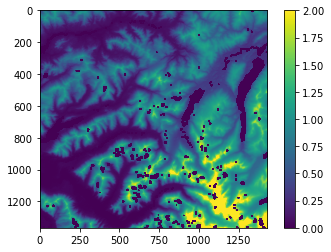

In [13]:
plt.imshow(np.squeeze(SMswe_cso[100,:,:]),vmin=0, vmax=2)
plt.colorbar()

In [14]:
swe_base = '/nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/baseline_swed.gdat'
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)

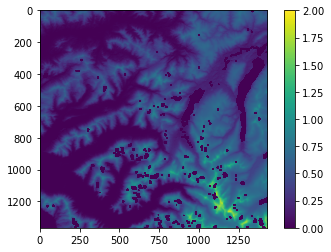

In [15]:
plt.imshow(np.squeeze(SMswe_base[100,:,:]),vmin=0, vmax=2)
plt.colorbar()

In [28]:
ctlFile = '/nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/swed.ctl'
#baseline SM run 
text = 'DSET ^baseline_swed.gdat\n'
replace_line(ctlFile, 0, text)
baseswe = open_CtlDataset(ctlFile)

# #cso assim SM run 
text = 'DSET ^cso_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
csoswe = open_CtlDataset(ctlFile)

# #snotel assim SM run 
text = 'DSET ^snotel_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
snotelswe = open_CtlDataset(ctlFile)

#both assim SM run 
text = 'DSET ^both_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
bothswe = open_CtlDataset(ctlFile)

In [13]:
ctlFile

'/nfs/attic/dfh/Aragon2/CSOgdat/OR/swed.ctl'

In [27]:
# #baseline SM run 
# text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/baseline_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# baseswe = open_CtlDataset(ctlFile)

# # #cso assim SM run 
# text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/cso_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# csoswe = open_CtlDataset(ctlFile)

# # #snotel assim SM run 
# text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/snotel_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# snotelswe = open_CtlDataset(ctlFile)

# #both assim SM run 
# text = 'DSET ^/nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/both_'+mode+'_swed.gdat\n'
# replace_line(ctlFile, 0, text)
# bothswe = open_CtlDataset(ctlFile)

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/attic/dfh/Aragon2/CSOgdat/WA_SQ//nfs/attic/dfh/Aragon2/CSOgdat/WA_SQ/both_all_swed.gdat'

In [125]:
#baseline SM run 
text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/baseline_swed.gdat\n'
replace_line(ctlFile, 0, text)
baseswe = open_CtlDataset(ctlFile)

In [23]:
baseswe

,Array,Chunk
Bytes,2.85 GB,7.81 MB
Shape,"(365, 1366, 1429)","(1, 1366, 1429)"
Count,730 Tasks,365 Chunks
Type,float32,numpy.ndarray


In [127]:
# #snotel assim SM run 
text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/snotel_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
snotelswe = open_CtlDataset(ctlFile)
snotelswe

,Array,Chunk
Bytes,1.48 GB,4.04 MB
Shape,"(365, 1231, 821)","(1, 1231, 821)"
Count,730 Tasks,365 Chunks
Type,float32,numpy.ndarray


In [128]:
# #cso assim SM run 
text = 'DSET /nfs/attic/dfh/Aragon2/CSOgdat/'+domain+'/cso_'+mode+'_swed.gdat\n'
replace_line(ctlFile, 0, text)
csoswe = open_CtlDataset(ctlFile)
csoswe

,Array,Chunk
Bytes,1.48 GB,4.04 MB
Shape,"(365, 1231, 821)","(1, 1231, 821)"
Count,730 Tasks,365 Chunks
Type,float32,numpy.ndarray


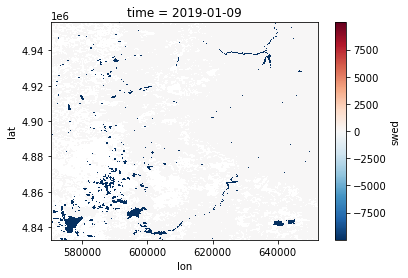

In [129]:
csoswe.swed.isel(time = 100).plot()

In [ ]:
baseswe = open_CtlDataset(ctlFile)

In [101]:
g_simple = baseswe.swed.plot(x="lon", y="lat", col="time", col_wrap=4)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3d5416a158> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# get snowmodel data 

dset = open_CtlDataset(ctlFile)

# print all the info in ctl file
print(dset)

In [18]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

In [24]:
i =0
nam = station[i]
el = elev[i]
obs = swes[nam].values
pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
mod = baseswe.swed.isel(lon = xval,lat = yval).values
plt.plot(mod,c='r')
plt.plot(obs)

NameError: name 'station' is not defined

In [ ]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
ds.SPEED.plot(x='longitude', y='latitude')
plt.scatter(ds.longitude, ds.latitude)

# I want to find the speed at a certain lat/lon point.
lat = 21.22
lon = -122.68

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(ds.latitude-lat)
abslon = np.abs(ds.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now I can use that index location to get the values at the x/y diminsion
point_ds = ds.sel(x=xloc, y=yloc)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
plt.scatter(point_ds.longitude, point_ds.latitude, color='r')
plt.text(point_ds.longitude, point_ds.latitude, 'nearest')

plt.title('speed at nearest point: %s' % point_ds.SPEED.data)

In [54]:
pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
pt

(572255.4512116197, 4908403.312312295)

In [62]:
abslat = np.abs(baseswe.lat-pt[0])
abslon = np.abs(baseswe.lon-pt[1])
c = np.maximum(abslon, abslat)
np.where(c == np.min(c))

(array([775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787,
        788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800,
        801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813,
        814, 815, 816, 817, 818, 819, 820]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))

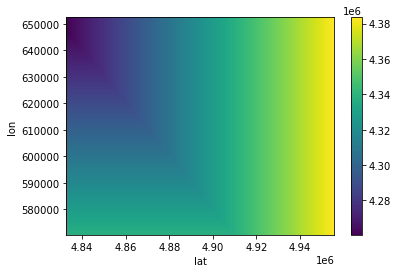

In [63]:
c.plot()

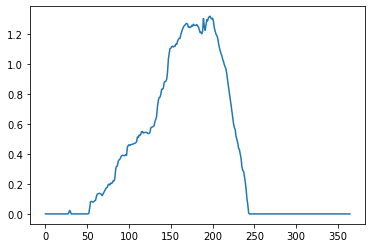

In [55]:
i =0
nam = station[i]
el = elev[i]
obs = swes[nam].values
pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
mod = baseswe.swed.isel(lon = yval,lat = xval).values
plt.plot(mod,c='r')
plt.plot(obs)

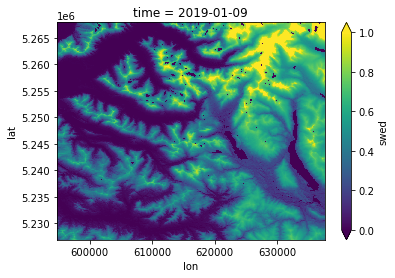

In [25]:
baseswe.swed.isel(time = 100).plot(vmin=0, vmax=1)

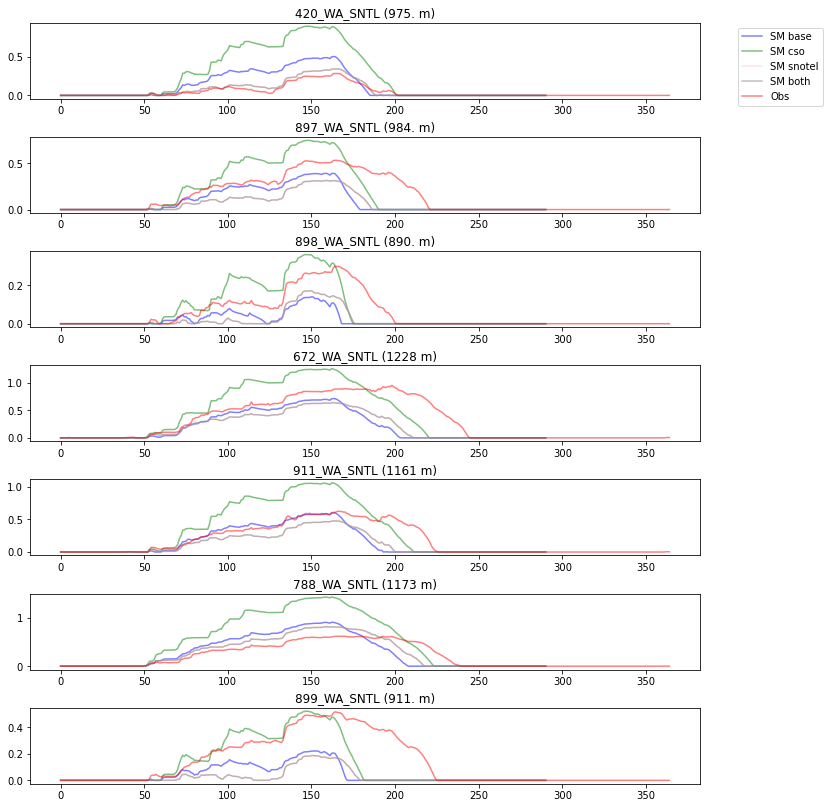

In [29]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
xll = float(domains[domain]['xll'])
yll = float(domains[domain]['yll'])
clsz = float(domains[domain]['cellsize'])
ny = float(domains[domain]['nrows'])
nx = float(domains[domain]['ncols'])

eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)


elev = snotelgdf['elevation_m'].values
station = snotelgdf['code'].values

#from matplotlib.pyplot import cm

#n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(snotelgdf), figsize=(12, 2*len(snotelgdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(snotelgdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = swes[nam].values
    pt = (snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,snotelgdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
    cso = csoswe.swed.isel(lon = xval,lat = yval).values
    snotel = snotelswe.swed.isel(lon = xval,lat = yval).values
    both = bothswe.swed.isel(lon = xval,lat = yval).values
    axs[i].plot(base,color='b', label ='SM base',alpha = 0.5)
    axs[i].plot(cso,color='g', label ='SM cso',alpha = 0.5)
    axs[i].plot(snotel,color='pink', label ='SM snotel',alpha = 0.5)
    axs[i].plot(both,color='grey', label ='SM both',alpha = 0.5)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

In [31]:
CSOgdf_clean

,geometry,id,author,depth,source,timestamp,elevation,swe,doy,H,dt,Y,M,D,x,y,iqr_flag
0,POINT (-121.40169 47.36165),Fbk3FwJ9,John Jennings,270.000000,SnowPilot,2019-02-17T21:30:00.000Z,942.587891,1.020045,140,2700.000000,2019-02-17,2019,2,17,620688.509333,5.246593e+06,True
1,POINT (-121.42084 47.44515),lZmZXpKU,Ely Gerbin,250.000000,SnowPilot,2019-02-16T20:30:00.000Z,1407.895874,0.947809,139,2500.000000,2019-02-16,2019,2,16,619054.199439,5.255843e+06,True
2,POINT (-121.34203 47.37864),7noQmjvA,James Maltman,219.999992,MountainHub,2019-02-11T22:12:57.239Z,1491.652100,0.829039,134,2199.999917,2019-02-11,2019,2,11,625153.209768,5.248575e+06,True
3,POINT (-121.34626 47.37786),opJsaw/b,James Maltman,184.999993,MountainHub,2019-02-11T21:00:32.509Z,1444.615356,0.697502,134,1849.999930,2019-02-11,2019,2,11,624835.694916,5.248481e+06,True
4,POINT (-121.20914 47.41401),NHqDdLfG,Chris Mayer,190.000000,SnowPilot,2019-02-03T00:00:00.000Z,1286.564331,0.656190,126,1900.000000,2019-02-03,2019,2,3,635094.367285,5.252728e+06,True
5,POINT (-121.45576 47.44966),b/VWMNOe,Mark Ryman,260.000000,SnowPilot,2019-01-20T20:50:00.000Z,1535.373169,0.917102,112,2600.000000,2019-01-20,2019,1,20,616412.026642,5.256291e+06,True
6,POINT (-121.38511 47.43543),hE77ZBPK,Eric Gold,114.999996,MountainHub,2018-12-28T17:21:11.342Z,1496.551758,0.380330,89,1149.999957,2018-12-28,2018,12,28,621770.833741,5.254817e+06,True
7,POINT (-121.39722 47.43178),jVwiEbNA,Richard Forbes,130.000000,MountainHub,2018-12-24T08:30:03.325Z,1408.360229,0.418941,85,1300.000000,2018-12-24,2018,12,24,620865.499120,5.254394e+06,True
8,POINT (-121.43901 47.43602),hZsdJUEt,Shane Robinson,125.000000,MountainHub,2018-12-16T21:14:49.089Z,1504.562988,0.388532,77,1250.000000,2018-12-16,2018,12,16,617704.736183,5.254800e+06,True
9,POINT (-121.45443 47.45202),+PZ+EQhO,Shane Robinson,145.000000,MountainHub,2018-12-15T19:48:35.060Z,1326.734497,0.454664,76,1450.000000,2018-12-15,2018,12,15,616507.158187,5.256555e+06,True


In [54]:
dates = pd.date_range(start=stdt, end=eddt)
dates.values

array(['2018-10-01T00:00:00.000000000', '2018-10-02T00:00:00.000000000',
       '2018-10-03T00:00:00.000000000', '2018-10-04T00:00:00.000000000',
       '2018-10-05T00:00:00.000000000', '2018-10-06T00:00:00.000000000',
       '2018-10-07T00:00:00.000000000', '2018-10-08T00:00:00.000000000',
       '2018-10-09T00:00:00.000000000', '2018-10-10T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-13T00:00:00.000000000', '2018-10-14T00:00:00.000000000',
       '2018-10-15T00:00:00.000000000', '2018-10-16T00:00:00.000000000',
       '2018-10-17T00:00:00.000000000', '2018-10-18T00:00:00.000000000',
       '2018-10-19T00:00:00.000000000', '2018-10-20T00:00:00.000000000',
       '2018-10-21T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2018-10-23T00:00:00.000000000', '2018-10-24T00:00:00.000000000',
       '2018-10-25T00:00:00.000000000', '2018-10-26T00:00:00.000000000',
       '2018-10-27T00:00:00.000000000', '2018-10-28

In [41]:
pd.to_datetime(CSOgdf_clean.dt.values)

DatetimeIndex(['2019-02-17', '2019-02-16', '2019-02-11', '2019-02-11',
               '2019-02-03', '2019-01-20', '2018-12-28', '2018-12-24',
               '2018-12-16', '2018-12-15'],
              dtype='datetime64[ns]', freq=None)

In [58]:
i=0
idx = np.where(pd.to_datetime(CSOgdf_clean.dt.iloc[i])==dates)

In [59]:
dates[idx]

DatetimeIndex(['2019-02-17'], dtype='datetime64[ns]', freq=None)

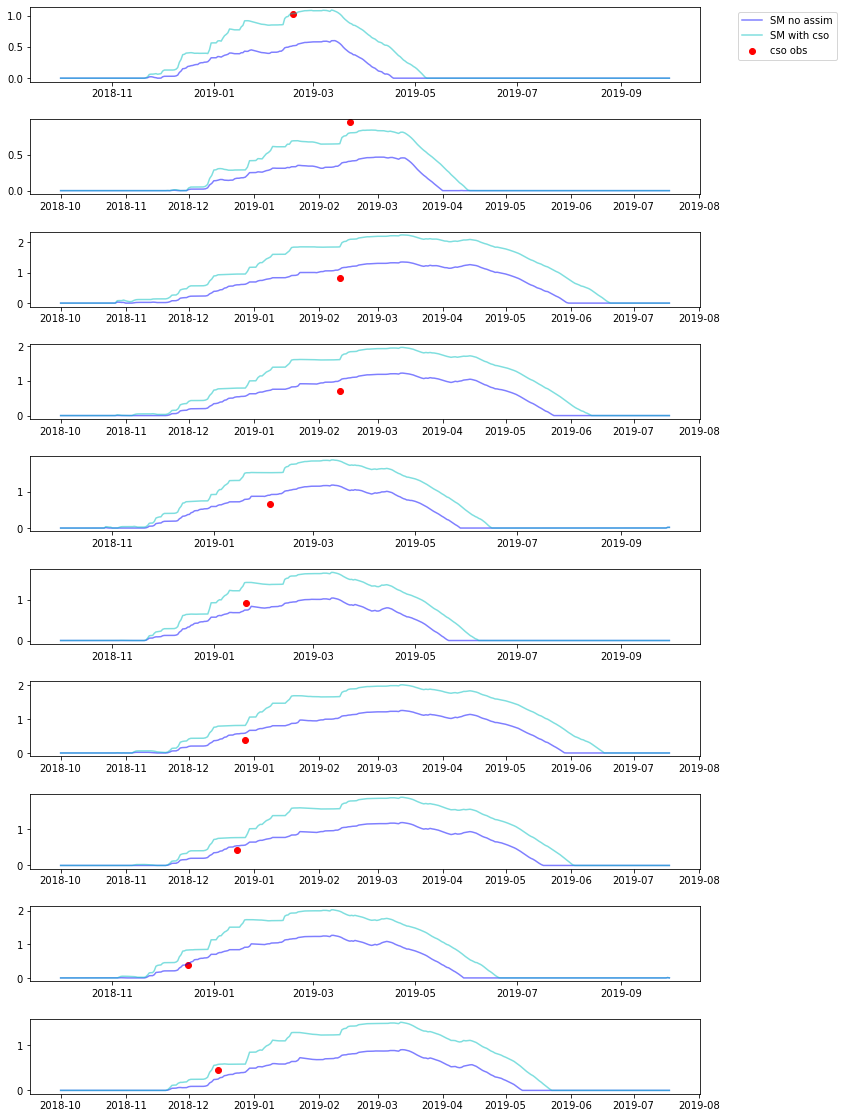

In [62]:
csogdf = CSOgdf_clean
dates = pd.date_range(start=stdt, end=eddt)
fig, axs = plt.subplots(nrows=len(csogdf), figsize=(12, 2*len(csogdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(csogdf)[0]):

    obs = csogdf.iloc[i].swe
    idx = np.where(pd.to_datetime(csogdf.dt.iloc[i])==dates) 
    pt = (csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    base = baseswe.swed.isel(lon = xval,lat = yval).values
    cso = csoswe.swed.isel(lon = xval,lat = yval).values
    axs[i].plot(dates,base,color='b', label ='SM no assim',alpha = 0.5)
    axs[i].plot(dates,cso,color='c', label ='SM with cso',alpha = 0.5)
    #axs[i].set_ylim([0, 2])
    axs[i].scatter(dates[idx],obs,color = 'r',label = 'cso obs')
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

Text(0, 0.5, 'SWE [m]')

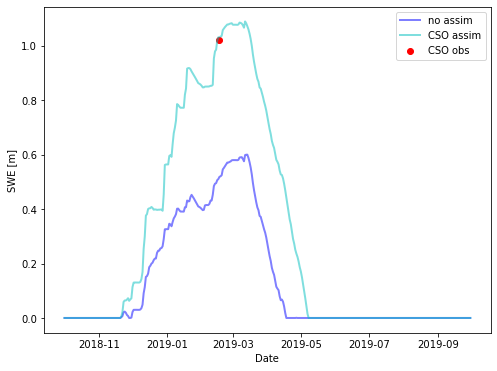

In [70]:
csogdf = CSOgdf_clean
dates = pd.date_range(start=stdt, end=eddt)
fig, axs = plt.subplots(1,figsize=(8,6),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
i = 0
obs = csogdf.iloc[i].swe
idx = np.where(pd.to_datetime(csogdf.dt.iloc[i])==dates) 
pt = (csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,csogdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
base = baseswe.swed.isel(lon = xval,lat = yval).values
cso = csoswe.swed.isel(lon = xval,lat = yval).values
axs.plot(dates,base,color='b', label ='no assim',alpha = 0.5,linewidth=2)
axs.plot(dates,cso,color='c', label ='CSO assim',alpha = 0.5,linewidth=2)
#axs[i].set_ylim([0, 2])
axs.scatter(dates[idx],obs,color = 'r',label = 'CSO obs')
axs.legend(loc='upper right',)
axs.set_xlabel('Date')
axs.set_ylabel('SWE [m]')

In [71]:
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'
path = figpath + 'CSOassim_example.png'
fig.savefig(path, dpi=300)